In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read train and test data
train_df = pd.read_csv("data/customer_service/train.csv")
test_df = pd.read_csv("data/customer_service/test.csv")

In [3]:
# Load the training dataset
df = train_df

In [4]:
# Show basic info
print("🔍 Dataset Overview:")
print(df.info())
print("\n First few rows:")
print(df.head())

🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   970 non-null    object
 1   issue_category               970 non-null    object
 2   issue_sub_category           970 non-null    object
 3   issue_category_sub_category  970 non-null    object
 4   customer_sentiment           970 non-null    object
 5   product_category             970 non-null    object
 6   product_sub_category         970 non-null    object
 7   issue_complexity             970 non-null    object
 8   agent_experience_level       970 non-null    object
 9   agent_experience_level_desc  970 non-null    object
 10  conversation                 970 non-null    object
dtypes: object(11)
memory usage: 83.5+ KB
None

🧮 First few rows:
                  issue_area                        issue_category  

In [6]:
# Check class distribution
print("\n Sentiment distribution:")
print(df['customer_sentiment'].value_counts())


 Sentiment distribution:
neutral     542
negative    411
positive     17
Name: customer_sentiment, dtype: int64


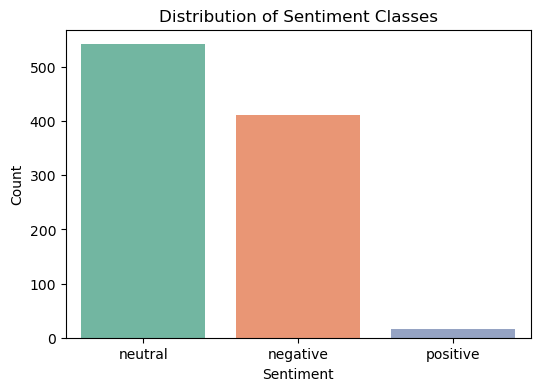

In [8]:
# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='customer_sentiment', data=df, palette='Set2')
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [9]:
# Add a column for conversation length (number of words)
df['conversation_length'] = df['conversation'].astype(str).apply(lambda x: len(x.split()))

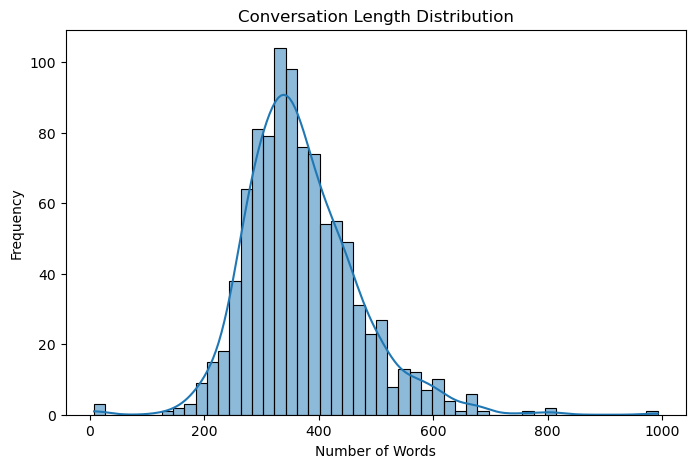

In [10]:
# Plot conversation length distribution
plt.figure(figsize=(8,5))
sns.histplot(df['conversation_length'], bins=50, kde=True)
plt.title("Conversation Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

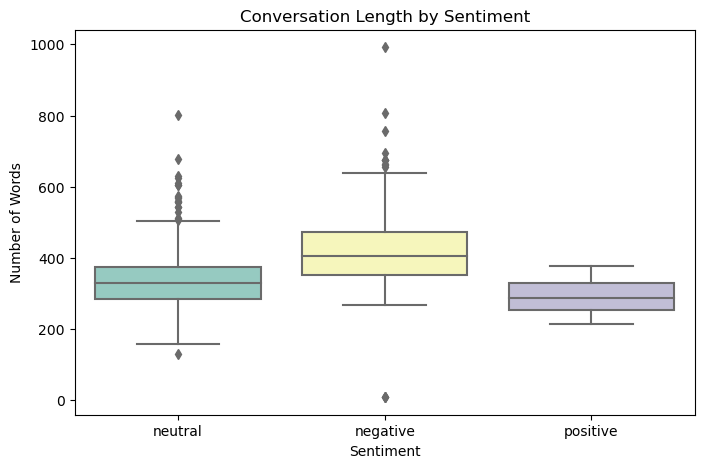

In [12]:
# Boxplot of length by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='customer_sentiment', y='conversation_length', data=df, palette='Set3')
plt.title("Conversation Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

In [14]:
# Print summary statistics
print("\n Conversation length stats by sentiment:")
print(df.groupby('customer_sentiment')['conversation_length'].describe())


 Conversation length stats by sentiment:
                    count        mean         std    min    25%    50%    75%  \
customer_sentiment                                                              
negative            411.0  417.666667  101.350242    8.0  351.5  406.0  471.5   
neutral             542.0  337.778598   80.600145  129.0  285.0  329.0  373.0   
positive             17.0  294.000000   48.175461  213.0  253.0  286.0  329.0   

                      max  
customer_sentiment         
negative            992.0  
neutral             802.0  
positive            378.0  


In [15]:
# Optional: Top 10 most common words per sentiment
from collections import Counter
import re

In [19]:
def clean_and_tokenize(text):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return words

for sentiment in df['customer_sentiment'].unique():
    all_words = df[df['customer_sentiment'] == sentiment]['conversation'].dropna().apply(clean_and_tokenize).sum()
    most_common = Counter(all_words).most_common(10)
    print(f"\n Top 10 words for sentiment '{sentiment}':")
    for word, freq in most_common:
        print(f"{word}: {freq}")


 Top 10 words for sentiment 'neutral':
you: 10137
the: 8133
i: 7617
to: 5118
customer: 5091
agent: 4899
for: 4784
your: 3917
that: 3792
and: 3519

 Top 10 words for sentiment 'negative':
i: 8852
you: 8011
the: 7641
for: 5111
to: 4592
customer: 4472
agent: 4290
your: 3625
that: 3473
and: 3347

 Top 10 words for sentiment 'positive':
you: 309
the: 215
i: 176
for: 158
agent: 153
customer: 150
your: 116
to: 114
order: 94
thank: 92


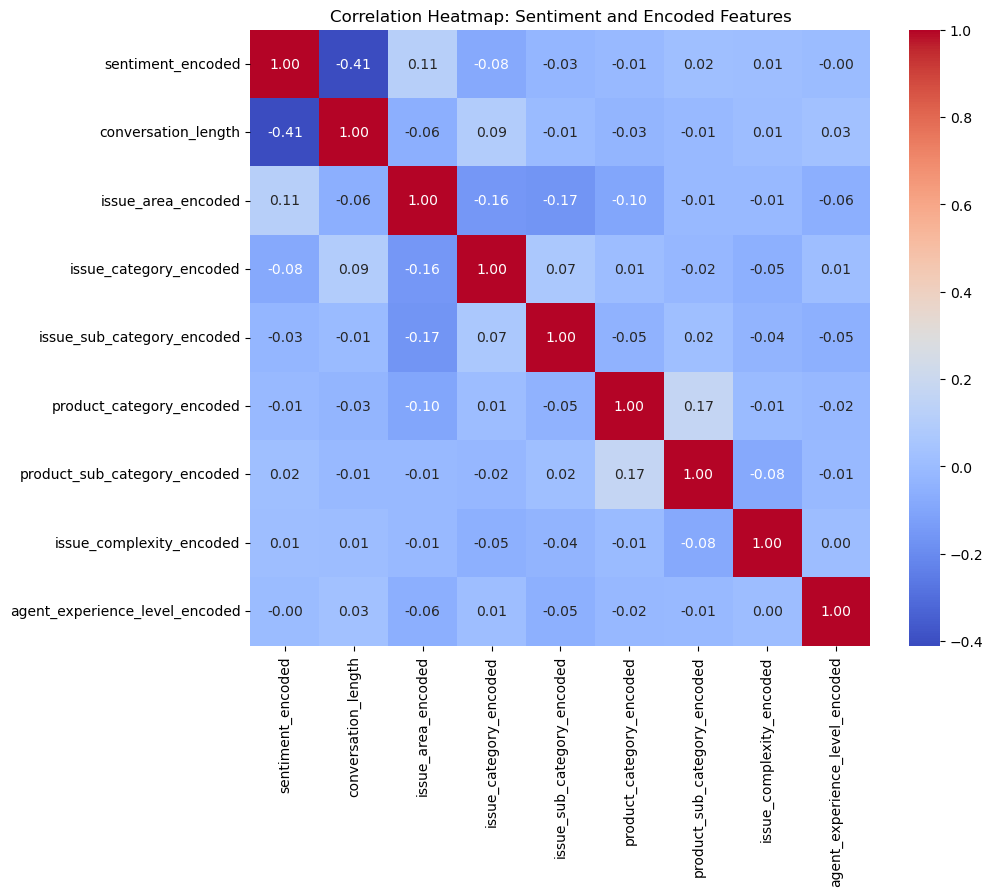

In [28]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Encode sentiment
df['sentiment_encoded'] = LabelEncoder().fit_transform(df['customer_sentiment'])

# Add conversation length
df['conversation_length'] = df['conversation'].astype(str).apply(lambda x: len(x.split()))

# List of categorical features to encode
categorical_features = [
    'issue_area',
    'issue_category',
    'issue_sub_category',
    'product_category',
    'product_sub_category',
    'issue_complexity',
    'agent_experience_level'
]

# Encode each categorical feature
for feature in categorical_features:
    df[feature + '_encoded'] = LabelEncoder().fit_transform(df[feature])

# Collect all numeric features to include in correlation
correlation_features = ['sentiment_encoded', 'conversation_length'] + [f + '_encoded' for f in categorical_features]

# Compute correlation matrix
corr_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Sentiment and Encoded Features")
plt.show()

In [29]:
from scipy.stats import chi2_contingency
import pandas as pd

# Define the list of categorical features to test
categorical_features = [
    'issue_area',
    'issue_category',
    'issue_sub_category',
    'product_category',
    'product_sub_category',
    'issue_complexity',
    'agent_experience_level'
]

# Function to perform chi-squared test and return full results
def chi_squared_test_with_interpretation(cat_column, target_column='customer_sentiment'):
    contingency = pd.crosstab(df[cat_column], df[target_column])
    chi2, p, dof, expected = chi2_contingency(contingency)
    if p < 0.05:
        interpretation = "✅ Significant association with sentiment (p < 0.05)"
    else:
        interpretation = "❌ No significant association (p ≥ 0.05)"
    print(f"{cat_column}: p = {p} — {interpretation}")
    return p

# Run test for each feature and collect results
chi_squared_results = {}

print("📊 Chi-Squared Test Results:\n")
for feature in categorical_features:
    p_value = chi_squared_test_with_interpretation(feature)
    chi_squared_results[feature] = p_value

# Optional: Convert results to DataFrame
chi_squared_df = pd.DataFrame.from_dict(chi_squared_results, orient='index', columns=['p_value'])
chi_squared_df.sort_values('p_value', inplace=True)


📊 Chi-Squared Test Results:

issue_area: p = 4.701404799126131e-31 — ✅ Significant association with sentiment (p < 0.05)
issue_category: p = 6.586367550645071e-172 — ✅ Significant association with sentiment (p < 0.05)
issue_sub_category: p = 1.9096427323686348e-274 — ✅ Significant association with sentiment (p < 0.05)
product_category: p = 0.14093108779287314 — ❌ No significant association (p ≥ 0.05)
product_sub_category: p = 0.7496001114503076 — ❌ No significant association (p ≥ 0.05)
issue_complexity: p = 0.5088975229960727 — ❌ No significant association (p ≥ 0.05)
agent_experience_level: p = 0.05492352706636956 — ❌ No significant association (p ≥ 0.05)


Use customer sentiment and conversation features, omit other columns.

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset (skip if already loaded)
df = pd.read_csv("data/customer_service/train.csv")  # update path as needed

# Step 1: Keep only relevant columns
df = df[['conversation', 'customer_sentiment']]

# Step 2: Drop any missing values just in case
df.dropna(inplace=True)

# Step 3: Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['customer_sentiment'])

# Step 4: Train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['sentiment_encoded']
)

# ✅ Output shapes
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")
# Save if needed
train_df.to_csv("train_processed.csv", index=False)
val_df.to_csv("val_processed.csv", index=False)

Train size: 873, Validation size: 97


Preprocessing Part

In [34]:
# Run data/customer_service/prepare_customer_sentiment.py